In [1]:
import pandas as pd
import numpy as np
import joblib as jb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('HR_Attrition_dataset.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head(1)

,Employee_ID,Age,Attrition,Business_Travel,Department,Distance_From_Home,Education,Environment_Satisfaction,Gender,Salary,Job_Involvement,Job_Level,Job_Role,Job_Satisfaction,Marital_Status,Number_of_Companies_Worked_previously,Overtime,Salary_Hike_in_percent,Total_working_years_experience,Work_life_balance,No_of_years_worked_at_current_company,No_of_years_in_current_role,Years_since_last_promotion
0,1,56,Yes,Travel Rarely,Network Administration,24,Graduation,5,Male,186630,2,6,Manager,4,Married,7,Yes,85,9,1,7,2,4


In [5]:
df['Attrition'] = df['Attrition'].map({'Yes':1, 'No':0})

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

In [7]:
X = df.drop(columns=['Employee_ID', 'Attrition'])
y = df[['Attrition']]

In [8]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numerical_transformer = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputation', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numeric_cols),
    ('cat', categorical_transformer, categoric_cols)
], remainder='passthrough')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, precision_recall_curve

lg_bal = LogisticRegression(max_iter=2000, 
                            class_weight='balanced', 
                            random_state=42,
                            solver='saga')

dt_bal = DecisionTreeClassifier(class_weight='balanced', random_state=42, criterion="log_loss",
                                max_depth=8, max_leaf_nodes=40, min_samples_leaf=10, min_samples_split=30)

rf_bal = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42, 
                                criterion='log_loss', max_depth=8, min_samples_split=30, 
                                max_leaf_nodes = 30, max_samples = 0.8,
                                min_samples_leaf = 10)

cat_bal = CatBoostClassifier(iterations=1500, learning_rate=0.03, class_weights=[1, 10], depth=6, random_seed=42,
                             eval_metric='AUC', loss_function='Logloss',
                             cat_features=categoric_cols, verbose=False)

In [12]:
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

In [13]:
df['oof_pred_lg'] = np.nan
df['oof_pred_rf'] = np.nan
df['oof_pred_dt'] = np.nan
df['oof_pred_cat'] = np.nan

In [14]:
lg_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('lg_bal', lg_bal)
])

dt_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('dt_bal', dt_bal)
])

rf_bal_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor), 
    ('rf_bal', rf_bal)
])

In [15]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    lg_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_lg'] = lg_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [16]:
df['pred_lg'] = (df['oof_pred_lg'] >= 0.45).astype(int)

In [17]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    rf_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_rf'] = rf_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [18]:
df['pred_rf'] = (df['oof_pred_rf'] >= 0.45).astype(int)

In [19]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    dt_bal_pipe.fit(X_train, y_train.values.ravel())
    df.loc[test_idx, 'oof_pred_dt'] = dt_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [20]:
df['pred_dt'] = (df['oof_pred_dt'] >= 0.45).astype(int)

In [21]:
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f'fold {i}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    cat_bal.fit(X_train, y_train.values.ravel(), cat_features=categoric_cols)
    df.loc[test_idx, 'oof_pred_cat'] = dt_bal_pipe.predict_proba(X_test)[:, 1]

fold 0
fold 1
fold 2
fold 3
fold 4


In [22]:
df['pred_cat'] = (df['oof_pred_cat'] >= 0.45).astype(int)

In [23]:
df.head()

,Employee_ID,Age,Attrition,Business_Travel,Department,Distance_From_Home,Education,Environment_Satisfaction,Gender,Salary,Job_Involvement,Job_Level,Job_Role,Job_Satisfaction,Marital_Status,Number_of_Companies_Worked_previously,Overtime,Salary_Hike_in_percent,Total_working_years_experience,Work_life_balance,No_of_years_worked_at_current_company,No_of_years_in_current_role,Years_since_last_promotion,oof_pred_lg,oof_pred_rf,oof_pred_dt,oof_pred_cat,pred_lg,pred_rf,pred_dt,pred_cat
0,1,56,1,Travel Rarely,Network Administration,24,Graduation,5,Male,186630,2,6,Manager,4,Married,7,Yes,85,9,1,7,2,4,0.328082,0.508110,0.604973,0.601164,0,1,1,1
1,2,46,1,Travel Rarely,Software Development,45,Degree,5,Male,78553,4,5,Help Desk,2,Divorced,3,No,22,18,4,1,2,0,0.149248,0.280128,0.256609,0.209119,0,0,0,0
2,3,32,0,No Travel,Data Science,30,Master's,3,Female,175003,1,4,HR,2,Single,2,Yes,100,0,4,5,5,8,0.672356,0.581653,0.470111,0.470111,1,1,1,1
3,4,60,1,Travel Frequently,Data Science,42,Graduation,2,Female,100795,2,8,Help Desk,3,Married,5,No,72,17,2,1,7,3,0.824443,0.690102,1.000000,1.000000,1,1,1,1
4,5,25,0,No Travel,Network Administration,26,Graduation,4,Female,75256,1,2,Director,4,Single,9,No,21,12,5,7,2,4,0.267222,0.391964,0.237824,0.259328,0,0,0,0


In [24]:
df['oof_pred_lg'] = round(df['oof_pred_lg'], 2)
df['oof_pred_rf'] = round(df['oof_pred_rf'], 2)
df['oof_pred_dt'] = round(df['oof_pred_dt'], 2)
df['oof_pred_cat'] = round(df['oof_pred_cat'], 2)

In [25]:
print(f'ROC-AUC score for logistic regression:-{roc_auc_score(y, df["oof_pred_lg"])}')
print(f'ROC-AUC score for Random Forest:-{roc_auc_score(y, df["oof_pred_rf"])}')
print(f'ROC-AUC score for Decision Tree:-{roc_auc_score(y, df["oof_pred_dt"])}')
print(f'ROC-AUC score for Catboost:-{roc_auc_score(y, df["oof_pred_cat"])}')

ROC-AUC score for logistic regression:-0.7534749888797945
ROC-AUC score for Random Forest:-0.8247911384604929
ROC-AUC score for Decision Tree:-0.8156049503728001
ROC-AUC score for Catboost:-0.8383880400374467


In [26]:
print(f'PR-AUC score for logistic regression:-{average_precision_score(y, df["oof_pred_lg"])}')
print(f'PR-AUC score for Random Forest:-{average_precision_score(y, df["oof_pred_rf"])}')
print(f'PR-AUC score for Decision Tree:-{average_precision_score(y, df["oof_pred_dt"])}')
print(f'PR-AUC score for Catboost:-{average_precision_score(y, df["oof_pred_cat"])}')

PR-AUC score for logistic regression:-0.5156152800003628
PR-AUC score for Random Forest:-0.6886490576857087
PR-AUC score for Decision Tree:-0.6948778782836198
PR-AUC score for Catboost:-0.7060277722795811


In [27]:
print(f'Confusion matrix for logistic regression:-\n{confusion_matrix(y, df["pred_lg"])}')
print(f'Confusion matrix score for Random Forest:-\n{confusion_matrix(y, df["pred_rf"])}')
print(f'Confusion matrix score for Decision Tree:-\n{confusion_matrix(y, df["pred_dt"])}')
print(f'Confusion matrix score for Catboost:-\n{confusion_matrix(y, df["pred_cat"])}')

Confusion matrix for logistic regression:-
[[4719 3034]
 [ 565 1682]]
Confusion matrix score for Random Forest:-
[[4784 2969]
 [ 380 1867]]
Confusion matrix score for Decision Tree:-
[[5043 2710]
 [ 495 1752]]
Confusion matrix score for Catboost:-
[[5159 2594]
 [ 432 1815]]


In [28]:
print(f'Classification report for logistic regression:-\n{classification_report(y, df["pred_lg"])}')
print(f'Classification report for Random Forest:-\n{classification_report(y, df["pred_rf"])}')
print(f'Classification report for Decision Tree:-\n{classification_report(y, df["pred_dt"])}')
print(f'Classification report for Catboost:-\n{classification_report(y, df["pred_cat"])}')

Classification report for logistic regression:-
              precision    recall  f1-score   support

           0       0.89      0.61      0.72      7753
           1       0.36      0.75      0.48      2247

    accuracy                           0.64     10000
   macro avg       0.62      0.68      0.60     10000
weighted avg       0.77      0.64      0.67     10000

Classification report for Random Forest:-
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      7753
           1       0.39      0.83      0.53      2247

    accuracy                           0.67     10000
   macro avg       0.66      0.72      0.63     10000
weighted avg       0.80      0.67      0.69     10000

Classification report for Decision Tree:-
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      7753
           1       0.39      0.78      0.52      2247

    accuracy                           0.68     10

In [29]:
tn, fn, fp, tp = confusion_matrix(y, df["pred_lg"]).ravel()

fnr = fn/(fn+tp)
fpr = fp/(fp+tn)
precision, recall, thresholds = precision_recall_curve(y, df['pred_lg'])

print(fnr, fpr)
print(np.mean(precision), np.mean(recall))

0.6433418150975403 0.10692657077971233
0.5271193949674866 0.5828512090194333


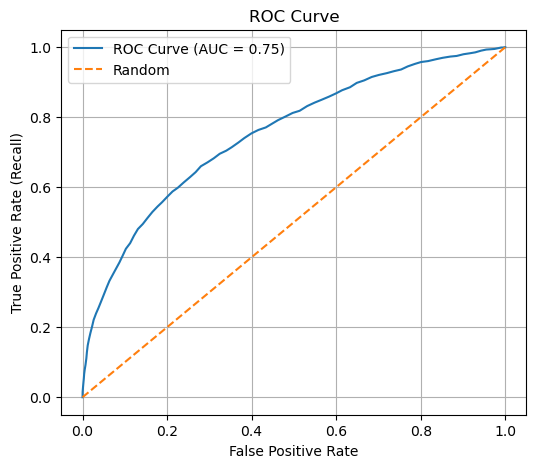

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, df['oof_pred_lg'])
roc_auc = roc_auc_score(y, df['oof_pred_lg'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

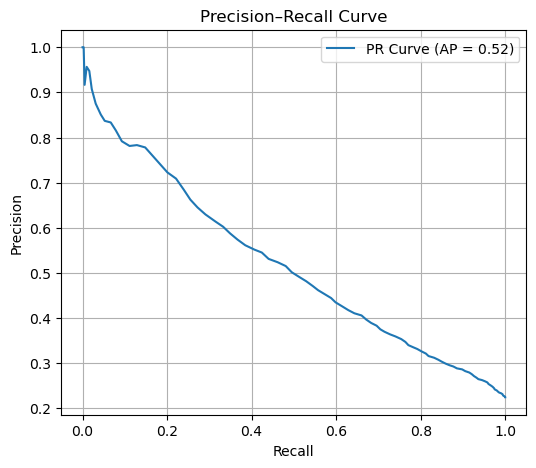

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_lg'])
pr_auc = average_precision_score(y, df['oof_pred_lg'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

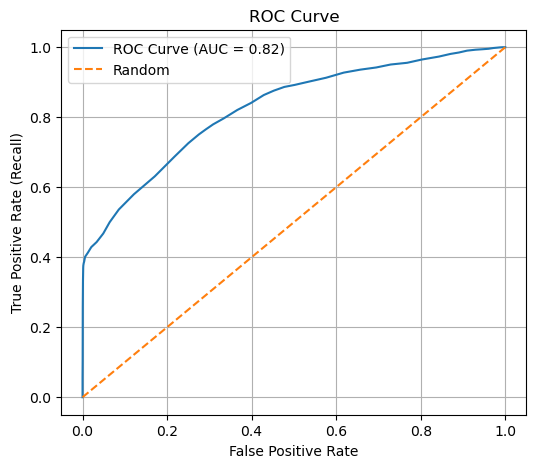

In [32]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_rf'])
roc_auc = roc_auc_score(y, df['oof_pred_rf'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

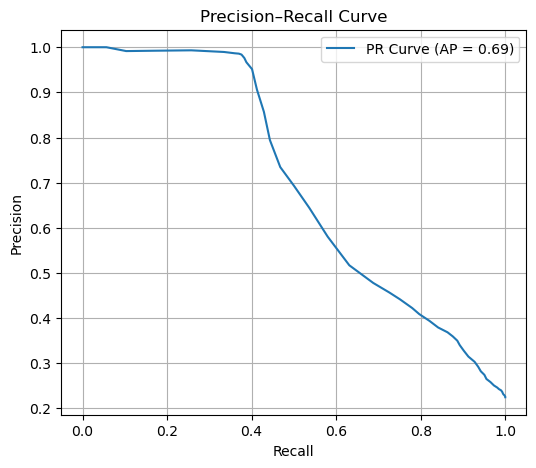

In [33]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_rf'])
pr_auc = average_precision_score(y, df['oof_pred_rf'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

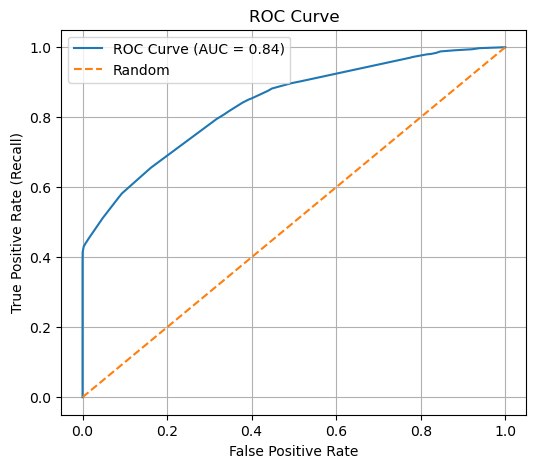

In [34]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_cat'])
roc_auc = roc_auc_score(y, df['oof_pred_cat'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

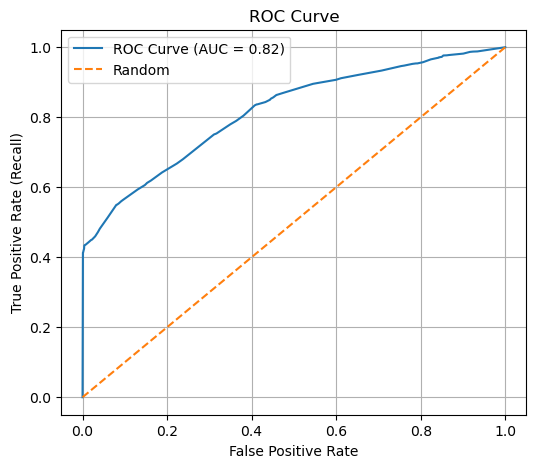

In [35]:
fpr, tpr, thresholds = roc_curve(y, df['oof_pred_dt'])
roc_auc = roc_auc_score(y, df['oof_pred_dt'])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

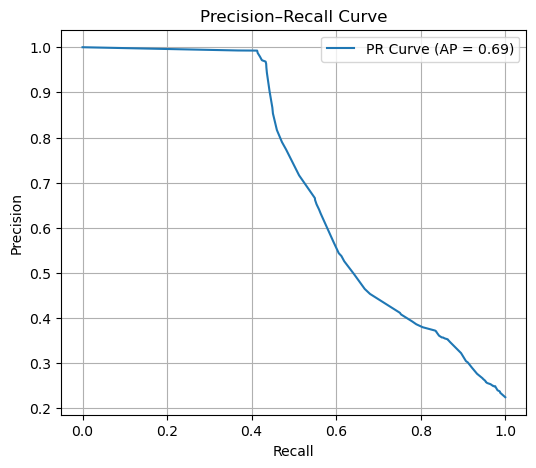

In [36]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_dt'])
pr_auc = average_precision_score(y, df['oof_pred_dt'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

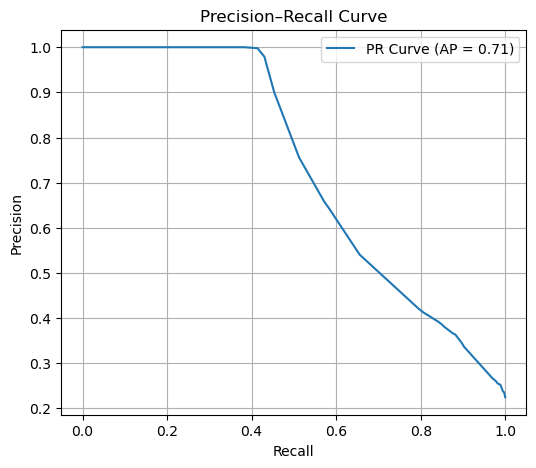

In [37]:
precision, recall, thresholds = precision_recall_curve(y, df['oof_pred_cat'])
pr_auc = average_precision_score(y, df['oof_pred_cat'])

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR Curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
tn, fp, fn, tp = confusion_matrix(y, df['pred_lg']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
lg_cm = {
    'model': 'Logistic Regression',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_rf']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
rf_cm = {
    'model': 'Random Forest',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_dt']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
dt_cm = {
    'model': 'Decision Tree',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

tn, fp, fn, tp = confusion_matrix(y, df['pred_cat']).ravel()
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
cat_cm = {
    'model': 'Catboost',
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn,
    'True Positives': tp,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall(TPR)': recall
}

In [39]:
cm_df = pd.DataFrame([lg_cm, rf_cm, dt_cm, cat_cm])

In [40]:
cm_df = cm_df.sort_values(by='False Negatives', ascending=True)

In [41]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR)
1,Random Forest,4784,2969,380,1867,0.6651,0.386063,0.830886
3,Catboost,5159,2594,432,1815,0.6974,0.411658,0.807744
2,Decision Tree,5043,2710,495,1752,0.6795,0.392649,0.779706
0,Logistic Regression,4719,3034,565,1682,0.6401,0.356658,0.748554


In [42]:
cm_df['Risk rate (FNR)'] = cm_df['False Negatives'] / (cm_df['False Negatives'] + cm_df['True Positives'])

In [43]:
cm_df['F1-score'] = 2*((cm_df['Precision']*cm_df['Recall(TPR)'])/(cm_df['Precision'] + cm_df['Recall(TPR)']))

In [44]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR),Risk rate (FNR),F1-score
1,Random Forest,4784,2969,380,1867,0.6651,0.386063,0.830886,0.169114,0.527178
3,Catboost,5159,2594,432,1815,0.6974,0.411658,0.807744,0.192256,0.545373
2,Decision Tree,5043,2710,495,1752,0.6795,0.392649,0.779706,0.220294,0.522283
0,Logistic Regression,4719,3034,565,1682,0.6401,0.356658,0.748554,0.251446,0.483125


In [45]:
cm_df['Risk rate (FNR)'] = round((cm_df['Risk rate (FNR)']*100), 2)

In [46]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR),Risk rate (FNR),F1-score
1,Random Forest,4784,2969,380,1867,0.6651,0.386063,0.830886,16.91,0.527178
3,Catboost,5159,2594,432,1815,0.6974,0.411658,0.807744,19.23,0.545373
2,Decision Tree,5043,2710,495,1752,0.6795,0.392649,0.779706,22.03,0.522283
0,Logistic Regression,4719,3034,565,1682,0.6401,0.356658,0.748554,25.14,0.483125


In [47]:
cm_df['Accuracy'] = round(cm_df['Accuracy'], 2)	
cm_df['Precision'] = round(cm_df['Precision'], 2)
cm_df['Recall(TPR)'] = round(cm_df['Recall(TPR)'], 2)	
cm_df['F1-score'] = round(cm_df['F1-score'], 2)

In [48]:
cm_df['threshold'] = 0.45

In [49]:
cm_df

,model,True Negatives,False Positives,False Negatives,True Positives,Accuracy,Precision,Recall(TPR),Risk rate (FNR),F1-score,threshold
1,Random Forest,4784,2969,380,1867,0.67,0.39,0.83,16.91,0.53,0.45
3,Catboost,5159,2594,432,1815,0.70,0.41,0.81,19.23,0.55,0.45
2,Decision Tree,5043,2710,495,1752,0.68,0.39,0.78,22.03,0.52,0.45
0,Logistic Regression,4719,3034,565,1682,0.64,0.36,0.75,25.14,0.48,0.45


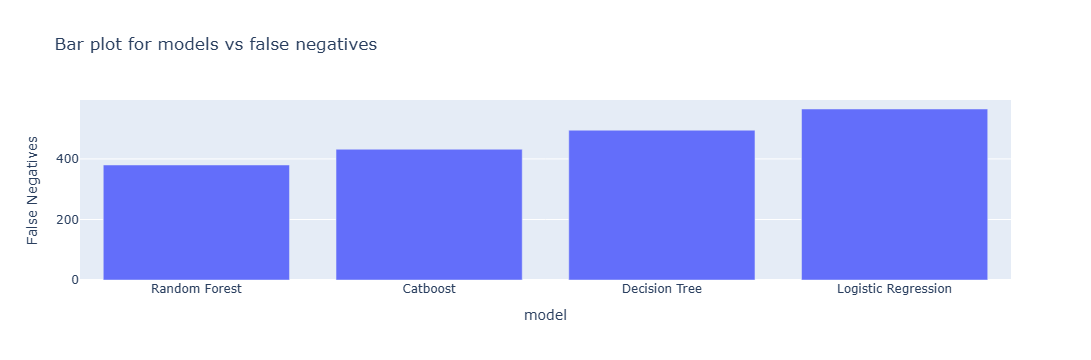

In [50]:
import plotly.express as px
px.bar(data_frame=cm_df, x=cm_df['model'], y=cm_df['False Negatives'], title='Bar plot for models vs false negatives')

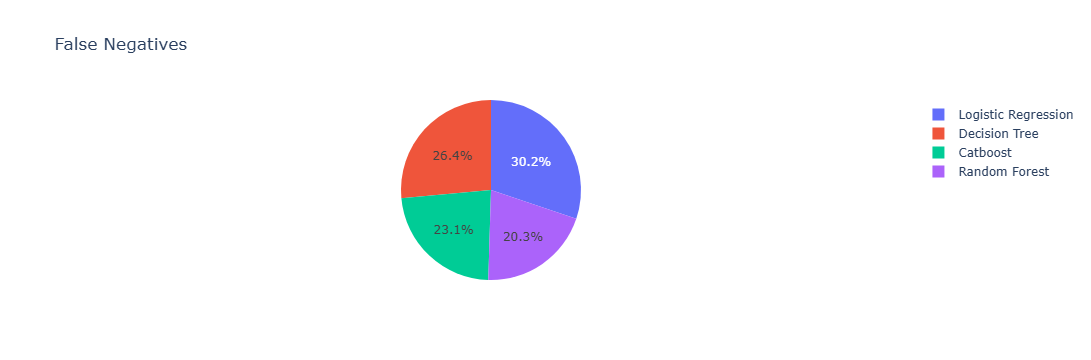

In [51]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['False Negatives'], title='False Negatives')

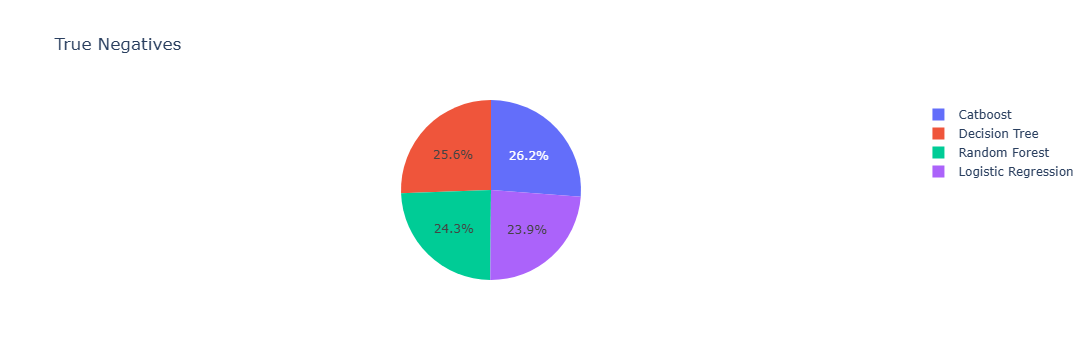

In [52]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['True Negatives'], title='True Negatives')

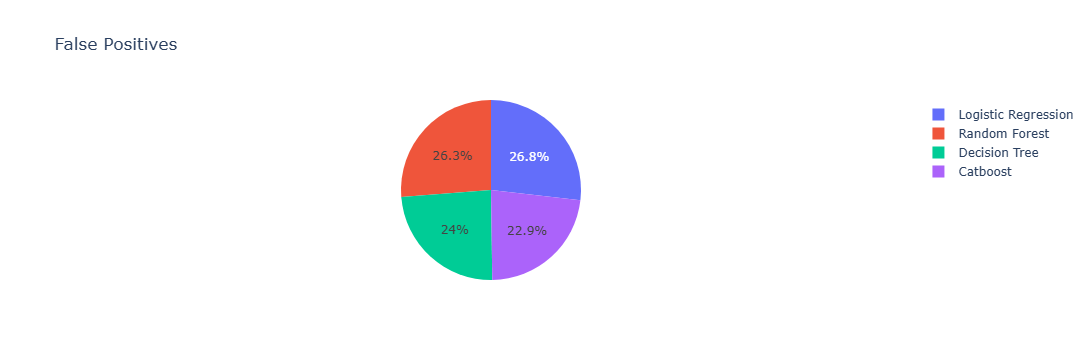

In [53]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['False Positives'], title='False Positives')

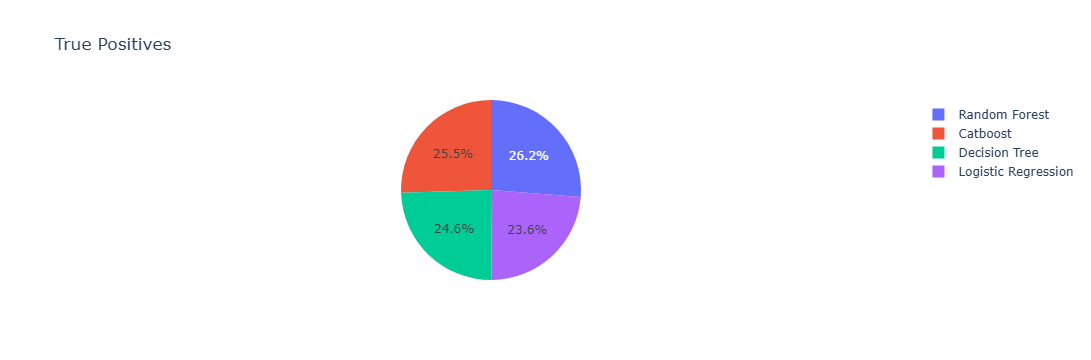

In [54]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['True Positives'], title='True Positives')

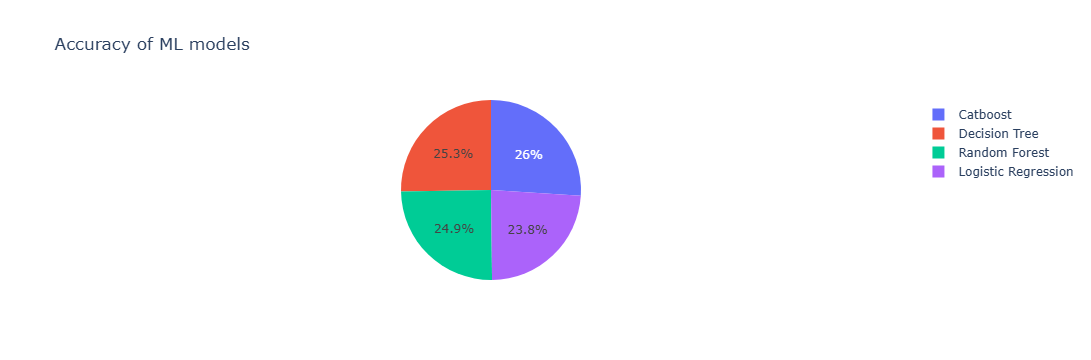

In [55]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['Accuracy'], title='Accuracy of ML models')

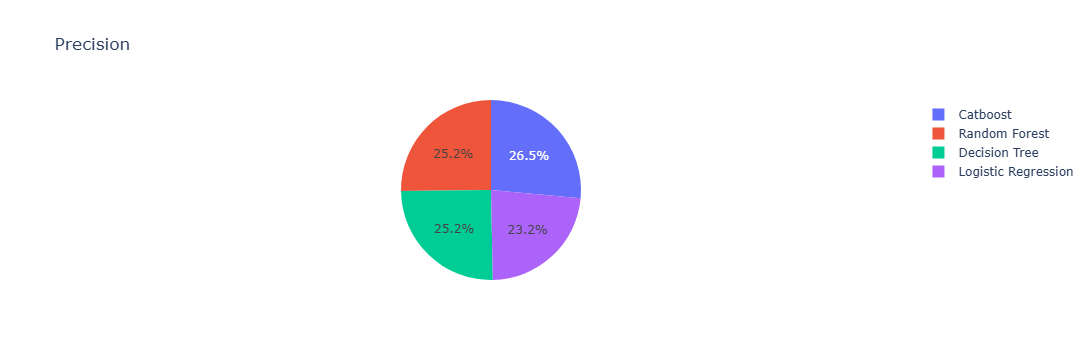

In [56]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['Precision'], title='Precision')

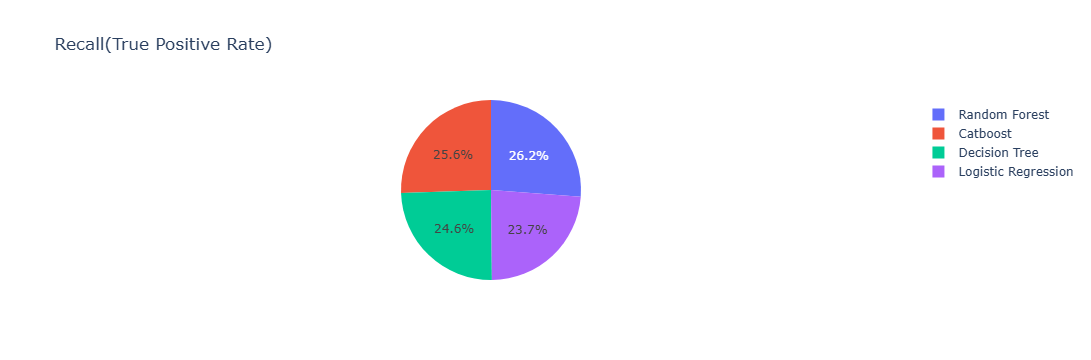

In [57]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['Recall(TPR)'], title='Recall(True Positive Rate)')

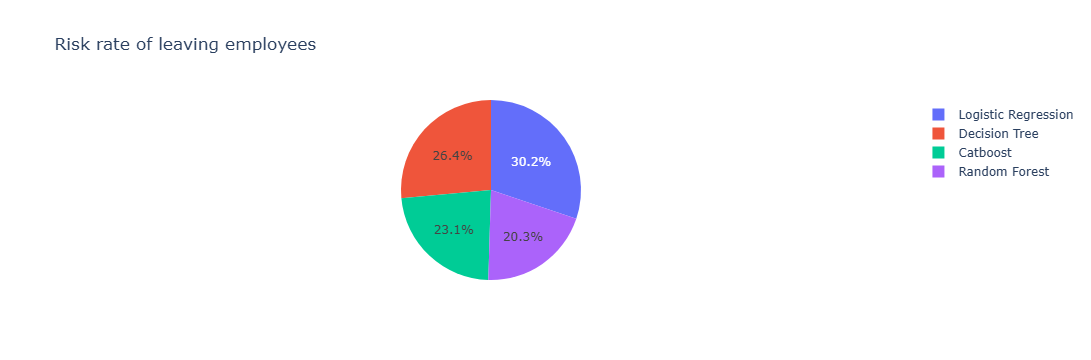

In [58]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['Risk rate (FNR)'], title='Risk rate of leaving employees')

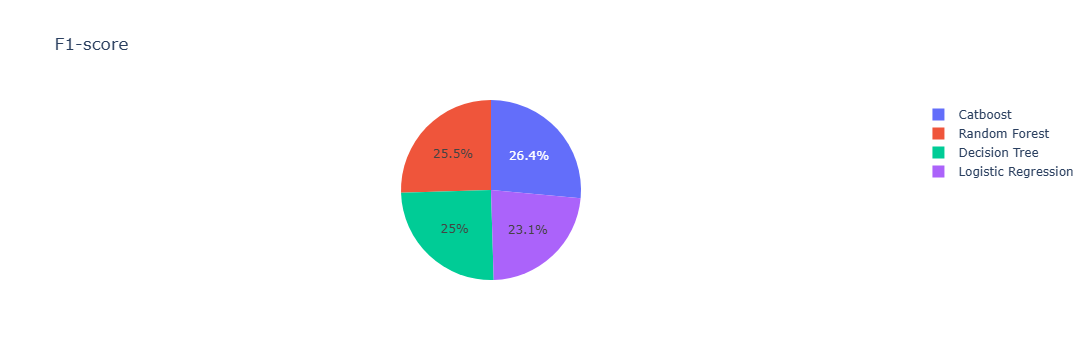

In [59]:
px.pie(data_frame=cm_df, names=cm_df['model'], values=cm_df['F1-score'], title='F1-score')

In [60]:
df['Attrition_label'] = df['Attrition'].map({1:'Yes', 0:'No'})

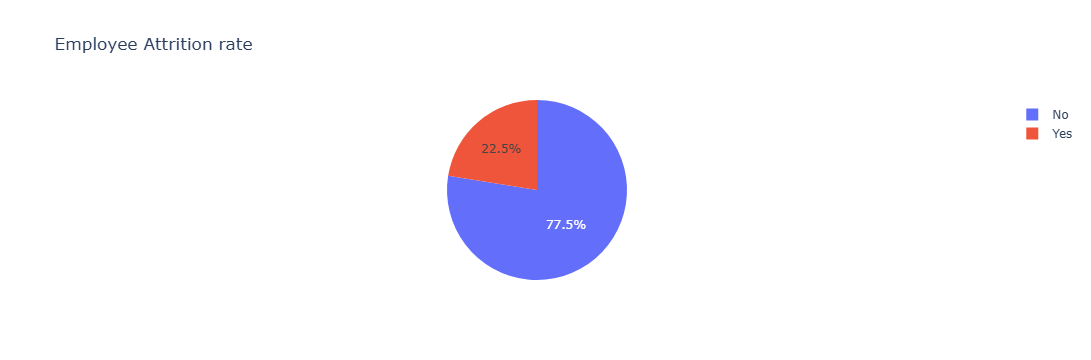

In [61]:
px.pie(data_frame=df, names=df['Attrition_label'], title="Employee Attrition rate")

In [62]:
df['Average_pred_proba'] = (df['oof_pred_lg'] + df['oof_pred_rf'] + df['oof_pred_dt'] + df['oof_pred_cat'])/4

In [63]:
df.head()

,Employee_ID,Age,Attrition,Business_Travel,Department,Distance_From_Home,Education,Environment_Satisfaction,Gender,Salary,Job_Involvement,Job_Level,Job_Role,Job_Satisfaction,Marital_Status,Number_of_Companies_Worked_previously,Overtime,Salary_Hike_in_percent,Total_working_years_experience,Work_life_balance,No_of_years_worked_at_current_company,No_of_years_in_current_role,Years_since_last_promotion,oof_pred_lg,oof_pred_rf,oof_pred_dt,oof_pred_cat,pred_lg,pred_rf,pred_dt,pred_cat,Attrition_label,Average_pred_proba
0,1,56,1,Travel Rarely,Network Administration,24,Graduation,5,Male,186630,2,6,Manager,4,Married,7,Yes,85,9,1,7,2,4,0.33,0.51,0.60,0.60,0,1,1,1,Yes,0.5100
1,2,46,1,Travel Rarely,Software Development,45,Degree,5,Male,78553,4,5,Help Desk,2,Divorced,3,No,22,18,4,1,2,0,0.15,0.28,0.26,0.21,0,0,0,0,Yes,0.2250
2,3,32,0,No Travel,Data Science,30,Master's,3,Female,175003,1,4,HR,2,Single,2,Yes,100,0,4,5,5,8,0.67,0.58,0.47,0.47,1,1,1,1,No,0.5475
3,4,60,1,Travel Frequently,Data Science,42,Graduation,2,Female,100795,2,8,Help Desk,3,Married,5,No,72,17,2,1,7,3,0.82,0.69,1.00,1.00,1,1,1,1,Yes,0.8775
4,5,25,0,No Travel,Network Administration,26,Graduation,4,Female,75256,1,2,Director,4,Single,9,No,21,12,5,7,2,4,0.27,0.39,0.24,0.26,0,0,0,0,No,0.2900


In [64]:
# Custom attrition risk bucket
bins = [0.0, 0.40, 0.65, 1.0] 
labels = ['Stay', 'Can Leave', 'Must Leave'] 
df['Attrition_risk_buckets'] = pd.cut(df['oof_pred_rf'], bins=bins, labels=labels)

In [66]:
risk_categories = pd.DataFrame(df['Attrition_risk_buckets'].value_counts(normalize=True).reset_index())

In [67]:
risk_categories

,Attrition_risk_buckets,proportion
0,Can Leave,0.5075
1,Stay,0.4105
2,Must Leave,0.0820


In [68]:
risk_categories['proportion'] = round(risk_categories['proportion']*100, 2)

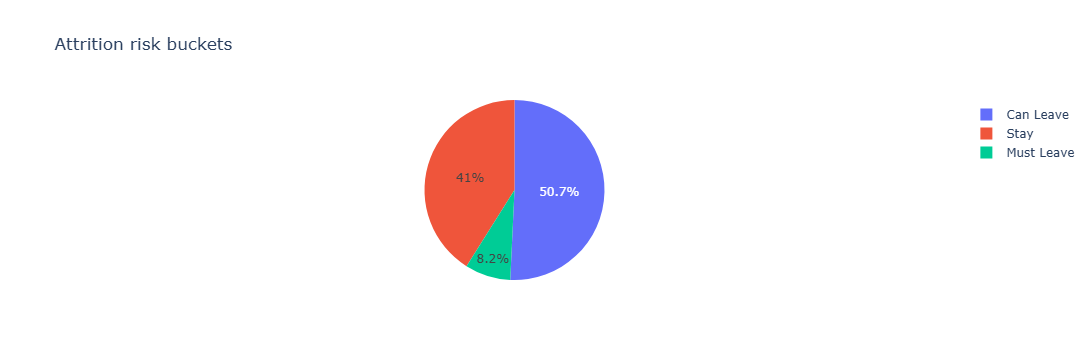

In [72]:
px.pie(data_frame=risk_categories, names='Attrition_risk_buckets', values='proportion', title='Attrition risk buckets')

## Based on the provided dataset of 10,000 employees, 7,753 employees are retained, while 2,247 employees have left the organization, resulting in an overall attrition rate of approximately 22.47%. This indicates a meaningful retention challenge and a moderately imbalanced target distribution.

## During model evaluation, multiple machine learning algorithms were compared with a focus on minimizing missed attrition risk (False Negative Rate), as failing to identify employees likely to leave has higher business impact. Among the evaluated models, Random Forest demonstrated the lowest attrition risk rate (FNR ≈ 16.91%), followed by CatBoost (≈ 19.23%), Decision Tree (≈ 22%), and Logistic Regression (≈ 25%). Based on this comparison, Random Forest was selected as the final model due to its superior ability to detect at-risk employees.

## Using the final Random Forest model, predicted probabilities were translated into business-oriented risk buckets to support actionable decision-making. The analysis shows that approximately 8.2% of employees fall into the high-risk (“must leave”) category, 50.7% are classified as medium risk (“can leave”), and 41% are categorized as low risk (“likely to stay”). This risk segmentation enables targeted retention strategies, allowing HR teams to prioritize interventions rather than applying blanket policies across the organization.